In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

import torch
#tf.enable_eager_execution()
%matplotlib inline

import sys
#sys.path.insert(1, '/Users/trentonbricken/protein-gen/pytorch/deep_boltzmann')

#from PlottingFunctions import *

import os
os.chdir('../pytorch')

from EVCouplingsGen import *
from evcouplings.couplings import CouplingsModel
from EVCouplingsStuff.seq_sele import *

from metropolis import MetropolisHastings
from utils import *

from nflib.MADE import *
from nflib.flows import *
from nflib.spline_flows import NSF_AR, NSF_CL
import itertools

import seaborn as sns
import matplotlib.pylab as plt

from evcouplings.couplings import CouplingsModel
from EVCouplingsStuff.seq_sele import *

from EVCouplingsGen import *

focus_seqs = read_fa('EVCouplingsStuff/DYR_ECOLI_1_b0.5.a2m_trimmed.fa')
evc_model = CouplingsModel('EVCouplingsStuff/DYR.model')
scores = evc_model.hamiltonians(list(focus_seqs['seq']))



In [4]:
seq_len = 2
enc_seqs=[]
for seq in focus_seqs['seq']:
    enc_seqs.append(encode_aa(seq[:seq_len], evc_model.alphabet_map)) 

enc_seqs = np.asarray(enc_seqs)
target_seq = enc_seqs[0]#encode_aa(np.char.upper(ali.matrix[0, :]), a2n)

oh = []
N=20 # none of these focus have gaps, else should be 21. 
for seq in enc_seqs:
    oh.append(onehot(seq,N))
oh=np.asarray(oh)

print('calculating weights and identities')
N = oh.shape[0]
L = oh.shape[1]
AA = oh.shape[2]
w, neighbors = msa_weights(enc_seqs, theta=0.8, pseudocount=0)
oh.shape

h = evc_model.h_i[:seq_len,:]
print(h.shape)
        
J = evc_model.J_ij[:seq_len, :seq_len, :, :]
print(J.shape)

calculating weights and identities
(2, 20)
(2, 2, 20, 20)


In [5]:
nat_energies = hamiltonians(oh, J, h)

In [6]:
nat_energies.shape

(7848,)

Plotting a hist of all the natural sequences energies:


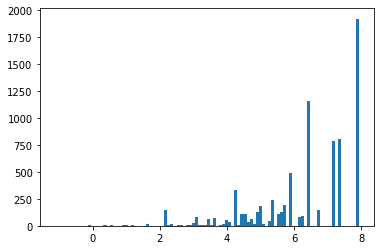

In [7]:
%matplotlib inline
plt.figure()

print('Plotting a hist of all the natural sequences energies:')
plt.hist(nat_energies, bins=100)
plt.show()

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
gen_model = EVCouplingsGenerator(L, AA, h, J, device)

In [10]:
evh_vals = []
for i in range(20):
    for j in range(20):
        seq = np.hstack([i,j])
        seq = seq.reshape(1,-1)
        ham = gen_model.energy(seq)
        #print(ham)
        evh_vals.append(ham)
evh_vals;

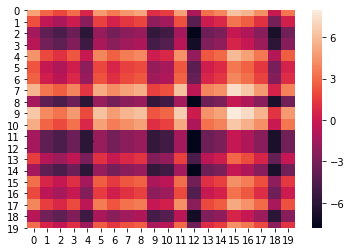

In [11]:
import seaborn as sns;
sns.heatmap(np.array(evh_vals).reshape(20,20).T)

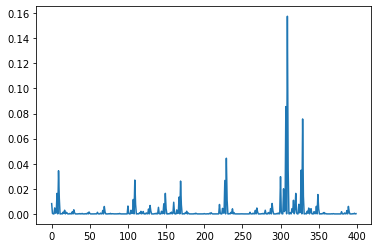

In [12]:
vals = evh_vals
probs = np.exp(vals) / np.sum(np.exp(vals))
plt.plot(probs)

In [13]:
max(vals)

array([7.93462935])

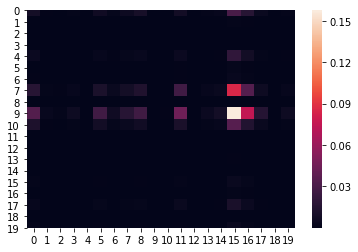

In [14]:
# this is the actual frequency with which I should be seeing different scores:
import seaborn as sns;
sns.heatmap(np.array(probs).reshape(20,20).T)

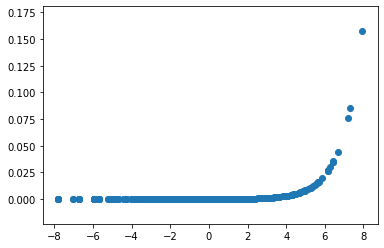

In [15]:
plt.scatter(evh_vals, probs)

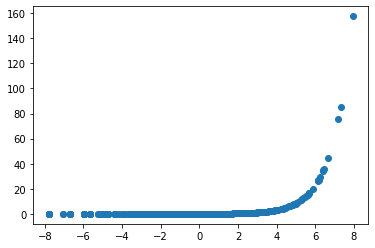

In [16]:
plt.scatter(evh_vals, probs*1000)

In [17]:
ls

EVCouplingsGen.py        debugger.py              run.py
EVCouplingsStuff/        evCouplings.py           run_bash_evCouplings.sh
PlottingFunctions.py     experiments/             utils.py
__pycache__/             metropolis.py
bash_evCouplings.sh      nflib/


In [24]:
base = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(gen_model.dim), torch.eye(gen_model.dim))

flows = [AffineHalfFlow(dim=gen_model.dim, parity=i%2, nh=32 ,scale=False) for i in range(4)]
flows.append(AffineConstantFlow(dim=gen_model.dim, shift=False))

network = NormalizingFlowModel(base, flows, gen_model)
#network.flow.to(device)


#network_RNVP_KLML = invnet(gen_model.dim, 'NNNNS', gen_model, nl_layers=3, nl_hidden=100, 
#                            nl_activation='relu', nl_activation_scale='tanh')

In [25]:


folder_name = '02_GPU_Analy_rand_seed-25_ML_epochs-1000_KL_epochs-1000_learning_rate-0.0001_MLweight-1.0_KLweight-1.0_explore1.0_temperature-1.0_s_time-2020-01-16_18_46_57.944733'
folder_name = folder_name.replace('/',':')
print(folder_name)
network.flow.load_state_dict(torch.load('experiments/'+folder_name+'/Model_Post_ML_KL_Training.torch', map_location=device))
    
# first_big_trainrand_seed-27_ML_epochs-1000_KL_epochs-5000_learning_rate-0.003_model_architecture-NNNNS_ML_weight-0.5_KL_weight-0.5_explore1.0_temperature-1.0_s_time-2019-11-09_00:15:40.315150Model_Post_KL_Training.tf 
#network_RNVP_KLML = network_RNVP_KLML.load('experiments/'+file_name+'/Model_Post_ML_KL_Training.torch', gen_model, clear_session=True)

02_GPU_Analy_rand_seed-25_ML_epochs-1000_KL_epochs-1000_learning_rate-0.0001_MLweight-1.0_KLweight-1.0_explore1.0_temperature-1.0_s_time-2020-01-16_18_46_57.944733


<All keys matched successfully>

In [34]:
num_gen = 1000
sample_x = network.sample(temperature=1.0, num_samples=num_gen).detach().numpy()

In [35]:
exp_energy_x = gen_model.energy(sample_x)

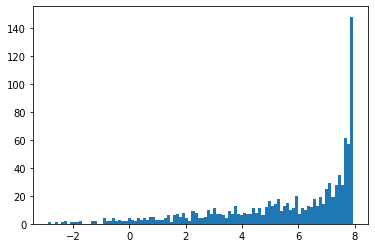

In [37]:
plt.hist(exp_energy_x, bins=100)
plt.show()

In [41]:
# want to arg max these sequences. Using numpy commands as .energy is in numpy rather than tensorflow. 
h_max = np.reshape(sample_x, (num_gen, gen_model.L, gen_model.AA_num ))
h_max = np.argmax(h_max, axis=-1)
h_max = np.reshape(h_max, (num_gen, gen_model.L ) )
# fed into energy as integers where they are then turned into onehots. 
#print('hard max is', h_max.shape)
hard_energy_x = gen_model.energy(h_max) / 1.0 


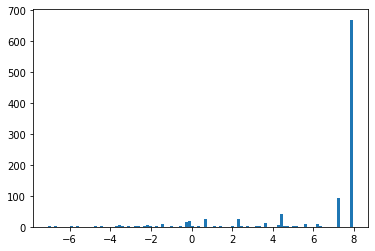

In [42]:
plt.hist(hard_energy_x, bins=100)
plt.show()

In [43]:
sample_x.shape

(1000, 40)

In [44]:
print( 'highest score natural sequence',  np.max(nat_energies), 'lowest', np.min(nat_energies))
print('highest score generated sequence', np.max(exp_energy_x), 'lowest', np.min(exp_energy_x))

highest score natural sequence 7.93462935090065 lowest -1.1265741577371955
highest score generated sequence 7.93454347795184 lowest -2.8792101460340134


In [46]:
print( 'means', np.mean(exp_energy_x), np.mean(nat_energies))

means 5.565496549607912 6.328940775453657


# Looking at the entropy and expected value of the sequences

In [78]:
from scipy.special import softmax
sm_x = sample_x.reshape(sample_x.shape[0], -1, 20)
sm_x = softmax(sm_x, axis=-1)
sm_x = sm_x.reshape(sm_x.shape[0], -1)
sm_x.shape

(1000, 40)

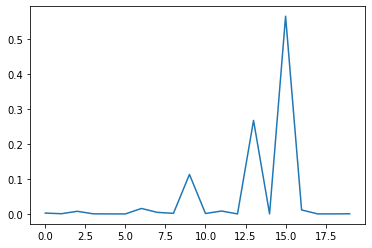

In [82]:
plt.plot(sm_x[0][0:20])
plt.show()

Text(0, 0.5, 'expected')

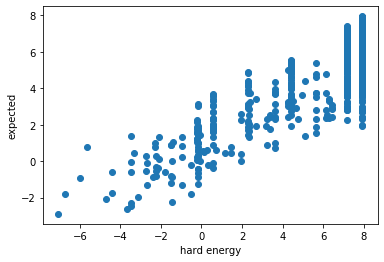

In [85]:
plt.scatter(hard_energy_x , exp_energy_x)
plt.xlabel('hard energy')
plt.ylabel('expected')

In [86]:
exp_max_ind = np.argmax(exp_energy_x)
exp_max_seq = sm_x[exp_max_ind]

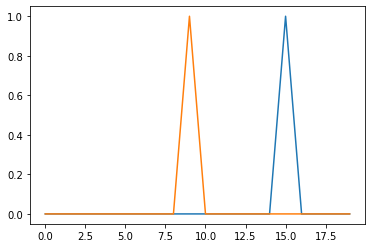

In [89]:
plt.plot(exp_max_seq[0:20])
plt.plot(exp_max_seq[20:])
plt.show()

In [47]:
def hard_max(inp):
    if inp.shape[1] > L: # if it isnt a sequence of ints, then all to one hot.  
        #print('the input to oh is', inp)

        if len(inp)>2:
            inp = inp.reshape(inp.shape[0], -1, 20)
        else:
            inp = inp.reshape(-1,20)

        inp = np.argmax(inp, axis=-1)
    return inp

In [48]:
x = hard_max(sample_x)
x.shape

(1000, 2)

In [49]:
x

array([[15,  9],
       [15,  9],
       [15,  9],
       ...,
       [15, 18],
       [15,  9],
       [15,  9]])

In [50]:
enc_seqs

array([[15,  9],
       [11,  9],
       [13,  7],
       ...,
       [16,  9],
       [ 1,  9],
       [16,  7]])

In [51]:
n2a = dict([(n, a) for a, n in gen_model.a2n.items()])  
n2a

{0: 'A',
 1: 'C',
 2: 'D',
 3: 'E',
 4: 'F',
 5: 'G',
 6: 'H',
 7: 'I',
 8: 'K',
 9: 'L',
 10: 'M',
 11: 'N',
 12: 'P',
 13: 'Q',
 14: 'R',
 15: 'S',
 16: 'T',
 17: 'V',
 18: 'W',
 19: 'Y',
 20: '-'}

In [52]:
def n_to_aa(inp):
    to_aa = []
    N=20 # none of these focus have gaps, else should be 21. 
    for seq in inp:
        st = ''
        for s in seq:
            st+= n2a[s]
        to_aa.append(st)
    to_aa=np.asarray(to_aa)
    return to_aa

generated


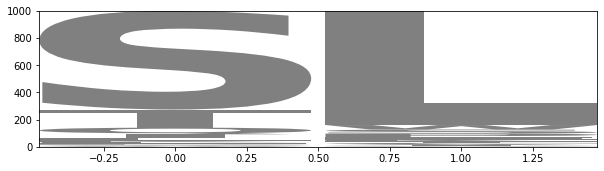

real


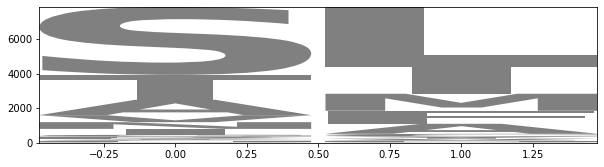

In [53]:
import logomaker as lm
names = ['generated', 'real']
for data, n in zip([x, enc_seqs], names):
    print(n)
    to_aa = n_to_aa(data)
    counts_mat = lm.alignment_to_matrix(to_aa)
    lm.Logo(counts_mat[0:50])
    plt.show()

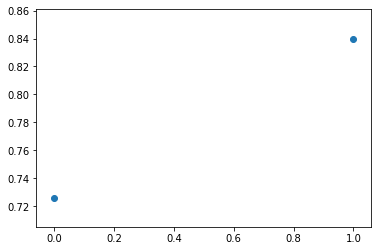

In [57]:
# looking at how similar different positions are between a particular x and the rest of hte x's
ind = 0
plt.scatter(np.arange(x.shape[1]),(x[ind] == x).sum(axis=0)/x.shape[0])

In [58]:
from scipy.spatial.distance import hamming
hamming([1, 0, 0], [0, 1, 0])

0.6666666666666666

In [59]:
# higher the value the more closely related they are. 

========= showing!  generated
selecting  100  for faster computation
(100, 100)
mean hamming 0.5704


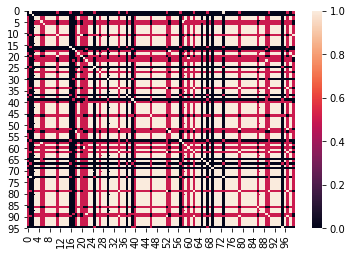

========= showing!  real
selecting  100  for faster computation
(100, 100)
mean hamming 0.2832


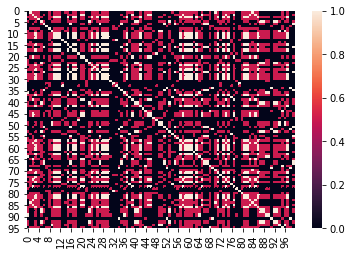

In [60]:

# plots N random sequences from the real and generated samples and sees how similar the sequences within these samples are. 
from scipy.spatial.distance import hamming, pdist, squareform
n_rand =100
names = ['generated', 'real']
for data, n in zip([x, enc_seqs], names):
    print('========= showing! ', n)
    
    print('selecting ', n_rand,' for faster computation')
    rand_inds =np.random.choice(np.arange(data.shape[0]), n_rand, replace=False)
    data = data[rand_inds, :]
    
    ham = 1- squareform(pdist(data, hamming))
    print(ham.shape)
    print('mean hamming', ham.mean())
    sns.heatmap(ham)
    plt.show()

# Looking at the similarities with MSA weights

In [61]:

gen_w, gen_neighbors = msa_weights(x, theta=0.8, pseudocount=0) # higher the theta the more closely they need to be related. 
w, neighbors = msa_weights(enc_seqs, theta=0.8, pseudocount=0)

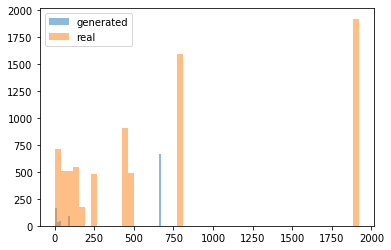

In [62]:
plt.hist(gen_neighbors, bins=50, alpha=0.5, label='generated')
plt.hist(neighbors, bins=50, alpha=0.5, label='real')
plt.legend()

In [63]:
comb_gen_nat= np.concatenate([x, enc_seqs], axis=0)
w_comb, n_comb = msa_weights(comb_gen_nat, theta=0.5, pseudocount=0)

0


/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


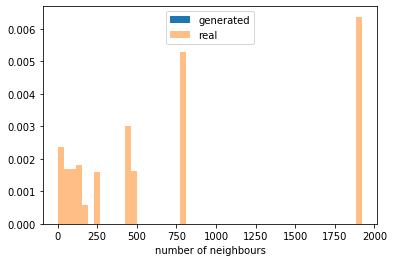

In [64]:

# only looking at those above a particular energy threshold: 

energy_cut = 600
num_x_kept = x[np.where(energy_x > energy_cut)].shape[0]
print(num_x_kept)
comb_fitgen_nat= np.concatenate([x[np.where(energy_x > energy_cut)], enc_seqs], axis=0)
w_combf, n_combf = msa_weights(comb_fitgen_nat, theta=0.6, pseudocount=0)

fig, ax = plt.subplots(1)
ax.hist(n_combf[:num_x_kept], bins=50, density=True, label='generated');
ax.hist(n_combf[num_x_kept:], bins=50, alpha=0.5, density=True, label='real');
plt.xlabel('number of neighbours')
plt.legend()
plt.show()

In [65]:
gen_w, gen_neighbors = msa_weights(x, theta=0.8, pseudocount=0) # higher the theta the more closely they need to be related. 
w, neighbors = msa_weights(enc_seqs, theta=0.8, pseudocount=0)

(array([238.,  92.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 670.]),
 array([  1. ,  67.9, 134.8, 201.7, 268.6, 335.5, 402.4, 469.3, 536.2,
        603.1, 670. ]),
 <a list of 10 Patch objects>)

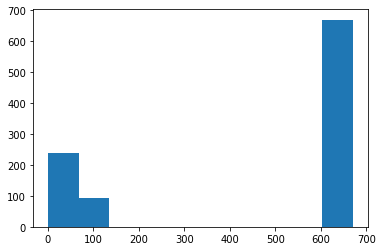

In [66]:
plt.hist(gen_neighbors)

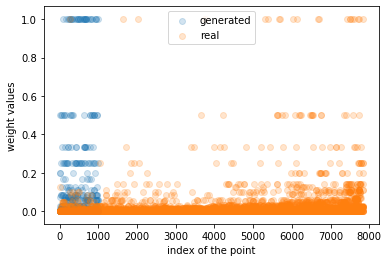

In [67]:
plt.scatter(np.arange(gen_w.shape[0]), gen_w,  alpha=0.2, label='generated')
plt.scatter(np.arange(w.shape[0]), w, alpha=0.2, label='real')
plt.ylabel('weight values')
plt.xlabel('index of the point')
plt.legend()

### UMAP the sequences to see how they cluster

In [68]:
import umap
import seaborn as sns
# sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})
reducer = umap.UMAP()

In [69]:
# converting the generated into a onehot: 
N= 20 # num of amino acids
x_oh = onehot(x, N)
x_oh= x_oh.reshape((x.shape[0], -1))
x_oh.shape

(1000, 40)

In [70]:
enc_oh = onehot(enc_seqs, N)
enc_oh= enc_oh.reshape((enc_oh.shape[0], -1))
enc_oh.shape

(7848, 40)

In [71]:
to_u = np.vstack([x_oh, enc_oh])
u_type = np.vstack([np.ones((x_oh.shape[0], 1)), np.zeros((enc_oh.shape[0], 1))])
print(to_u.shape, u_type.shape)

(8848, 40) (8848, 1)


In [72]:
reducer.fit(enc_oh)

/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/lib/python3.7/site-packages/uma

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=False)

In [73]:
embedding = reducer.transform(to_u)
embedding.shape


/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/lib/python3.7/site-packages/umap/nndescent.py", line 124:
    @numba.njit(parallel=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  state.func_ir.loc))
/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../anaconda3/lib/python3.7/site-packages/umap

(8848, 2)

In [82]:
u_type = list(u_type)
len(u_type)

9848

In [83]:
sns.color_palette()[1]

(1.0, 0.4980392156862745, 0.054901960784313725)

In [84]:
nat_energies.mean()

661.5509413136783

In [86]:
embedding.shape

(9848, 2)

In [87]:
nat_energies.shape

(7848,)

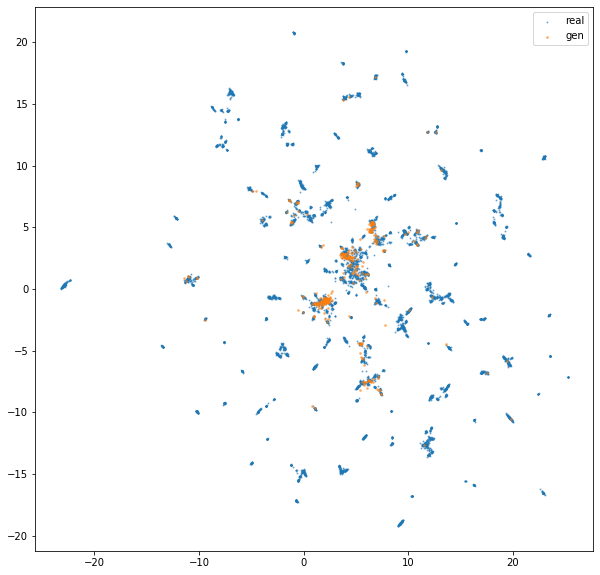

In [88]:
E = 600
#num_gen = 2000
plt.scatter(embedding[num_gen:, 0][nat_energies>E], embedding[num_gen:, 1][nat_energies>E], s=1, alpha=0.5, label='real')
plt.scatter(embedding[0:num_gen, 0][energy_x > E], embedding[0:num_gen, 1][energy_x > E], s=3, alpha=0.5, label='gen')
plt.gcf().set_size_inches(10,10)
plt.legend();

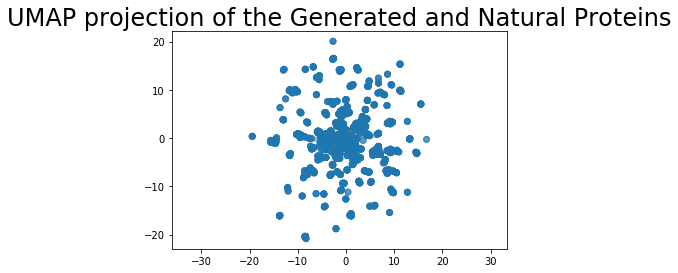

In [70]:
#plt.scatter(embedding[:, 0], embedding[:, 1], c=u_type, cmap='Spectral', s=5)
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[int(x)] for x in u_type], alpha=0.2)
plt.gca().set_aspect('equal', 'datalim')
#plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the Generated and Natural Proteins', fontsize=24);

In [82]:
#for x in u_type:
#    print(x)